In [1]:
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
ERROR: huggingface-hub 0.20.2 has requirement packaging>=20.9, but you'll have packaging 20.3 which is incompatible.


In [3]:
!pip install --upgrade diffusers[flax]

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 1.8 MB 1.4 MB/s 
     |████████████████████████████████| 4.4 MB 57.7 MB/s 
     |████████████████████████████████| 226 kB 94.3 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 534 kB 82.6 MB/s 
     |████████████████████████████████| 199 kB 94.1 MB/s 
     |████████████████████████████████| 81 kB 14.1 MB/s 
     |████████████████████████████████| 13.5 MB 74.3 MB/s 
     |████████████████████████████████| 240 kB 83.8 MB/s 
     |████████████████████████████████| 133 kB 105.2 MB/s 
     |████████████████

In [10]:
!pip install ipywidgets

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 139 kB 1.3 MB/s 
     |████████████████████████████████| 2.3 MB 8.8 MB/s 
     |████████████████████████████████| 214 kB 93.0 MB/s 


In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

tpu


In [5]:
import jax
import jax.numpy as jnp

In [6]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [11]:
#from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline

In [12]:
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

In [23]:
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    revision="bf16",
    dtype=jnp.bfloat16,
)

Fetching 15 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128135.56it/s]
/home/grigo/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /home/grigo/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/eb5fd1048921a4f94e627038e4107dfe7c68aca2/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_mode

In [15]:
prompts = [
    "Three leopards holding a scarlet rose and in the centre a green rat.",
    "A large glass bottle full of tiny elephants of different colors",
    "HAL-9000 in the style of Picasso",
    "Pink panther drinking a coffee. ",
    "Golden tiger fighting vikings in a modern city, Van Gogh style",
    "A blue Axolotl sitting on an emerald throne.",
    "A pumpkin-shape spaceship spinning around the Moon",
    "Black panther doing his homework",
]

In [16]:
p_params = replicate(params)

In [17]:
prompt_ids = pipeline.prepare_inputs(prompts)
prompt_ids = shard(prompt_ids)

In [18]:
seed = 42
rng = jax.random.PRNGKey(seed)
rng = jax.random.split(rng, jax.device_count())

In [19]:
images = pipeline(prompt_ids, p_params, rng, jit=True).images

In [20]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

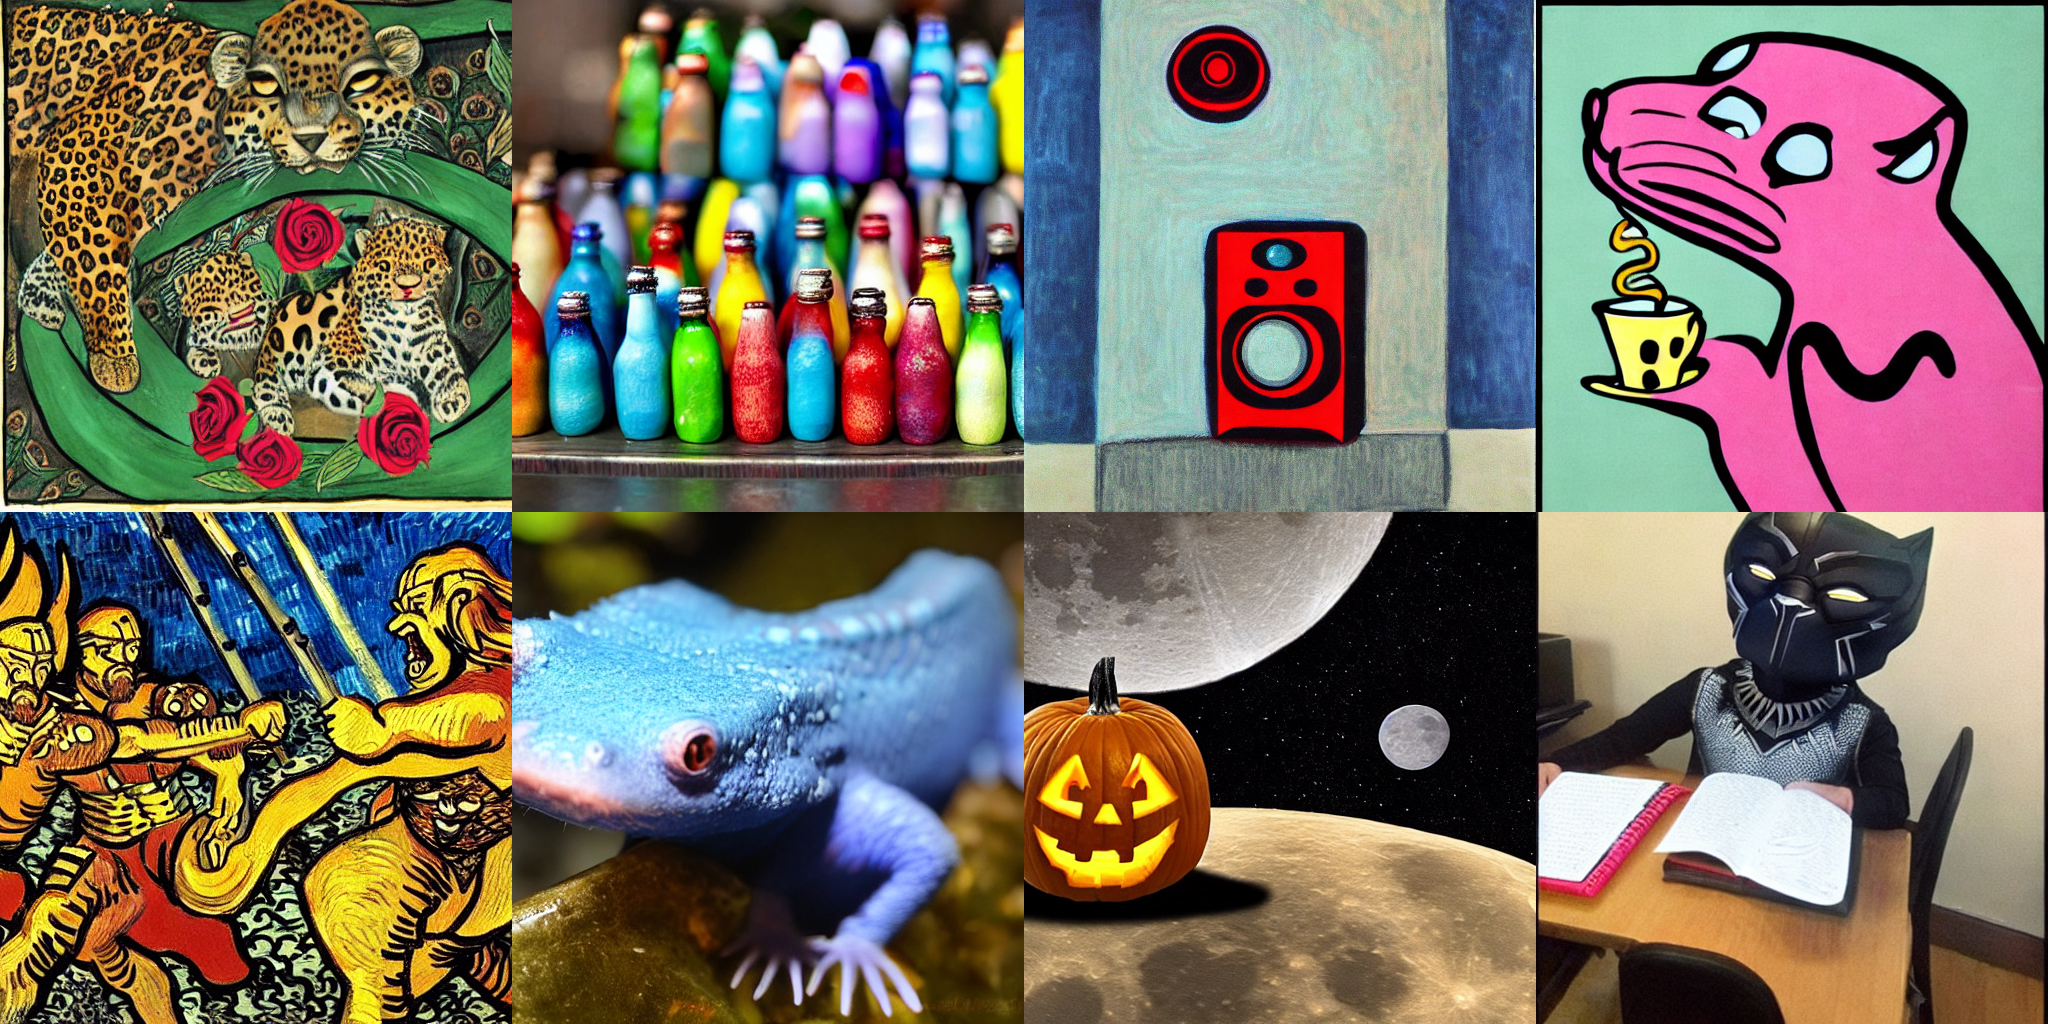

In [21]:
images = images.reshape((images.shape[0], ) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)
image_grid(images, 2, 4)